In [1]:
from transformers import AutoConfig, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForTokenClassification
import pandas as pd
from seqeval.metrics import classification_report
from itertools import chain

from named_entity_recognition.utils import read_dataset, tokenize_adjust_inputs
from named_entity_recognition.visualization import  tag_text
from named_entity_recognition.metrics import prepare_compute_metrics, compute_predictions_loss, plot_confusion_matrix
from named_entity_recognition.model import XLMRobertaForTokenClassification

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
xlmr_model_name = 'xlm-roberta-base'
device = 'cuda'

### Dataset reading

In [4]:
langs = ['de']
fracs = [0.629]
panx_ch = read_dataset(langs=langs, fracs=fracs)

### Model

In [5]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
id2label = {id: label for id, label in enumerate(tags.names)}
label2id = {label: id for id, label in enumerate(tags.names)}

In [6]:
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name, 
    num_labels=tags.num_classes, 
    label2id=label2id, 
    id2label=id2label
)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    config=xlmr_config
).to(device)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['clf.1.bias', 'clf.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
text = 'Jack Sparrow loves New York!'
tag_text(text, tags, model, tokenizer, device)

,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
input_ids,0,21763,37456,15555,5161,7,2356,5753,38,2
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,B-LOC


In [9]:
example = panx_ch['de']['train'][0]
example_tokenized = tokenizer(example['tokens'], is_split_into_words=True)
pd.DataFrame({
    'tokens': example_tokenized.tokens(),
    'word_ids': example_tokenized.word_ids()
}).T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
word_ids,NaN,0.0,1.0,1.0,2.0,3.0,4.0,4.0,4.0,5.0,...,9.0,9.0,9.0,9.0,10.0,10.0,10.0,11.0,11.0,NaN


In [10]:
panx_ch['de'] = panx_ch['de'].map(tokenize_adjust_inputs, batched=True, batch_size=None, 
                                  fn_kwargs={'tokenizer': tokenizer}, remove_columns=['langs', 'ner_tags', 'tokens'])

In [11]:
panx_ch['de']

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 6290
    })
})

In [12]:
example = panx_ch['de']['train'][0]
pd.DataFrame({
    'tokens': tokenizer.convert_ids_to_tokens(example['input_ids']),
    'input_ids': example['input_ids'],
    'labels': example['labels']
}).T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
input_ids,0,70101,176581,19,142,122,2290,708,1505,18363,...,13787,14,15263,18917,663,6947,19,6,5,2
labels,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100


### Model training

In [13]:
learning_rate = 3e-5
weight_decay = 1e-5
num_epochs = 5
batch_size = 32
logging_steps = len(panx_ch['de']['train']) // batch_size

data_collator = DataCollatorForTokenClassification(tokenizer)
compute_metrics = prepare_compute_metrics(id2label=id2label)

training_args = TrainingArguments(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    output_dir=f'{xlmr_model_name}_panx_de',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps
)

trainer = Trainer(
    model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    train_dataset=panx_ch['de']['train'],
    eval_dataset=panx_ch['de']['validation']
)

/home/tgniazdo/miniconda3/envs/ner/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.299200,0.163331,0.818008
2,0.138900,0.144020,0.841546
3,0.098000,0.139084,0.851743
4,0.074600,0.141014,0.858905
5,0.058000,0.140442,0.864868


TrainOutput(global_step=1970, training_loss=0.13355423693124413, metrics={'train_runtime': 184.5133, 'train_samples_per_second': 340.897, 'train_steps_per_second': 10.677, 'total_flos': 1524904939915896.0, 'train_loss': 0.13355423693124413, 'epoch': 5.0})

### Loss value analysis

In [15]:
panx_ch['de']['validation'] = panx_ch['de']['validation'].map(compute_predictions_loss, batched=True, batch_size=32, 
                          fn_kwargs={'trainer': trainer, 'data_collator': data_collator, 'device': 'cuda'})

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [16]:
panx_ch['de']['validation'].set_format('pandas')
panx_ch_de_val = panx_ch['de']['validation'][:]

In [17]:
panx_ch_de_val['preds_truncated'] = panx_ch_de_val.apply(lambda row: row['preds'][:len(row['input_ids'])], axis=1)
panx_ch_de_val['loss_truncated'] = panx_ch_de_val.apply(lambda row: row['loss'][:len(row['input_ids'])], axis=1)
panx_ch_de_val['loss_mean'] = panx_ch_de_val['loss_truncated'].apply(lambda l: sum(l) / len(l))

panx_ch_de_val['input_tokens'] = panx_ch_de_val['input_ids'].apply(lambda input_ids: tokenizer.convert_ids_to_tokens(input_ids))
panx_ch_de_val['labels_str'] = panx_ch_de_val['labels'].apply(lambda labels: [id2label[label] for label in labels if label != -100])
panx_ch_de_val['preds_str'] = panx_ch_de_val.apply(
    lambda row: [id2label[pred] for pred, label in zip(row['preds_truncated'], row['labels']) if label != -100], axis=1)
panx_ch_de_val.head(3)

,labels,input_ids,preds,loss,preds_truncated,loss_truncated,loss_mean,input_tokens,labels_str,preds_str
0,"[-100, 3, -100, 4, 4, 4, -100]","[0, 10699, 11, 15, 16104, 1388, 2]","[3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[0.0, 0.0059908824, 0.0, 0.0040899212, 0.0038678849, 0.0035706118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3, 3, 4, 4, 4, 4, 4]","[0.0, 0.0059908824, 0.0, 0.0040899212, 0.0038678849, 0.0035706118, 0.0]",0.002503,"[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]","[B-ORG, I-ORG, I-ORG, I-ORG]","[B-ORG, I-ORG, I-ORG, I-ORG]"
1,"[-100, 0, -100, -100, -100, -100, 3, -100, -100, 4, -100, -100, -100, -100, -100, 4, -100, -100]","[0, 56530, 25216, 30121, 152385, 19229, 83982, 1002, 170, 10, 434, 188, 31721, 299, 170, 57, 15263, 2]","[4, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[0.0, 0.00023970116, 0.0, 0.0, 0.0, 0.0, 0.1380564, 0.0, 0.0, 0.050116777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053239316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[0.0, 0.00023970116, 0.0, 0.0, 0.0, 0.0, 0.1380564, 0.0, 0.0, 0.050116777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053239316, 0.0, 0.0]",0.013425,"[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a, w, to, mobil, ny, j, ▁sa, wod, </s>]","[O, B-ORG, I-ORG, I-ORG]","[O, B-ORG, I-ORG, I-ORG]"
2,"[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, 0, -100, -100]","[0, 159093, 165, 38506, 122, 153080, 29088, 57432, 339, 304, 142, 6, 5, 2]","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.00016902448, 0.0001402995, 0.00016103878, 0.00014280253, 0.10944366, 0.0, 0.0, 0.2103234, 0.0, 0.00014435203, 0.00013243275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.00016902448, 0.0001402995, 0.00016103878, 0.00014280253, 0.10944366, 0.0, 0.0, 0.2103234, 0.0, 0.00014435203, 0.00013243275, 0.0, 0.0]",0.022904,"[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, tral, klasse, ▁L, 2, ▁an, ▁, ., </s>]","[O, O, O, O, B-ORG, O, O, O]","[O, O, O, O, B-ORG, O, O, O]"


#### Best predictions by loss

In [18]:
panx_ch_de_val.sort_values(by='loss_mean', ascending=True)[['input_tokens', 'labels_str', 'preds_str', 'loss_truncated', 'loss_mean']].head(5)

,input_tokens,labels_str,preds_str,loss_truncated,loss_mean
3800,"[<s>, ▁Zeit, ▁seine, s, ▁Lebens, ▁be, fan, d, ▁er, ▁sich, ▁in, ▁einem, ▁, wissenschaftlich, en, ▁Wett, stre, it, ▁mit, ▁seinem, ▁„, Ri, val, en, “, ▁Alfred, ▁Rad, cliff, e, -, Bro, wn, ▁, ., </s>]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O]","[0.0, 0.00016509123, 0.00013970352, 0.0, 0.00014828535, 0.00012182447, 0.0, 0.0, 0.00011288482, 0.00012659225, 0.000114553564, 0.000115983916, 0.00026985342, 0.0, 0.0, 0.0001913126, 0.0, 0.0, 0.00013302872, 0.00013243275, 0.00026663562, 0.0, 0.0, 0.0, 0.0, 0.000892241, 0.00095298165, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012468515, 0.0, 0.0]",0.000115
5930,"[<s>, ▁Zur, zeit, ▁res, id, iert, ▁dort, ▁die, ▁Familie, ▁von, ▁'', Ja, mes, ▁Her, vey, -, Ba, thur, st, ▁'', ▁, ,, ▁dem, ▁Enkel, ▁von, ▁Arthur, ▁Som, ers, -, Co, cks, ▁, ., </s>]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, O]","[0.0, 0.000114791954, 0.0, 0.00011979816, 0.0, 0.0, 9.97732e-05, 0.00014518638, 0.00017057394, 0.0001643761, 0.00024828213, 0.0, 0.0, 0.00033778208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001822544, 0.00011705667, 0.0, 0.000117295065, 0.00015686711, 0.00016139635, 0.0010032388, 0.0010406323, 0.0, 0.0, 0.0, 0.0, 0.0001294529, 0.0, 0.0]",0.000127
429,"[<s>, ▁15, ▁von, ▁Fr, édé, ric, ▁Cho, pin, ▁, ,, ▁das, ▁auch, ▁als, ▁„, Reg, en, trop, fen, -, P, ré, lu, de, “, ▁bekannt, ▁geworden, ▁ist, ▁, ., </s>]","[O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O]","[O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O]","[0.0, 0.00018821376, 0.00015305301, 0.0010964817, 0.0, 0.0, 0.0011475652, 0.0, 0.00013791563, 0.0, 0.00012826097, 0.00011860621, 0.00012146689, 0.00021765247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012242045, 0.00011741426, 0.00012146689, 0.00017260015, 0.0, 0.0]",0.000128
2021,"[<s>, ▁Eine, ▁neue, ▁Stat, ue, ▁, ,, ▁geschaffen, ▁nach, ▁einem, ▁Ent, wur, f, ▁von, ▁Albert, -, Er, n, est, ▁Car, rier, -, B, elle, use, ▁, ,, ▁Vater, ▁des, ▁zuerst, ▁genannten, ▁Künstler, s, ▁, ,, ▁er, setzt, e, ▁sie, ▁1998, ▁, ., </s>]","[O, O, O, O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O]","[0.0, 0.000114911156, 0.00011801023, 0.00032717598, 0.0, 0.00014316011, 0.0, 0.000117533455, 0.00011252724, 0.000107878586, 0.00015090757, 0.0, 0.0, 0.00013600854, 0.001031939, 0.0, 0.0, 0.0, 0.0, 0.0013771107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00021574555, 0.0, 0.0003338495, 0.00016020445, 0.0001402995, 0.00014232576, 0.00018082414, 0.0, 0.00012992969, 0.0, 0.00012623466, 0.0, 0.0, 0.00011383839, 0.00013290952, 0.00013243275, 0.0, 0.0]",0.000129
96,"[<s>, ▁Bee, in, fluss, t, ▁wurde, ▁er, ▁unter, ▁anderem, ▁von, ▁Bart, hol, ome, us, ▁Bre, enberg, h, ▁, ,, ▁mit, ▁dem, ▁er, ▁auch, ▁eng, ▁be, freunde, t, ▁war, ▁, ., </s>]","[O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O]","[0.0, 0.00013398226, 0.0, 0.0, 0.0, 0.000110143315, 0.00012051333, 0.000120155746, 0.00012706903, 0.00011991736, 0.0012457952, 0.0, 0.0, 0.0, 0.0008768766, 0.0, 0.0, 0.00015436411, 0.0, 0.00012694983, 0.00012551951, 0.00011765265, 0.000112646434, 0.00012492354, 0.00013040646, 0.0, 0.0, 0.00011276563, 0.0001619923, 0.0, 0.0]",0.000130


#### Worst predictions by loss

In [19]:
panx_ch_de_val.sort_values(by='loss_mean', ascending=False)[['input_tokens', 'labels_str', 'preds_str', 'loss_truncated', 'loss_mean']].head(5)

,input_tokens,labels_str,preds_str,loss_truncated,loss_mean
5009,"[<s>, ▁'', 8, ., ▁Juli, ▁'', ▁:, ▁Protest, camp, ▁auf, ▁dem, ▁Gelände, ▁der, ▁Republika, n, ischen, ▁Gar, de, </s>]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[O, O, O, O, O, O, O, O, O, B-ORG, I-ORG]","[0.0, 9.524379, 0.0, 0.0, 7.5387983, 9.31413, 9.290243, 7.983507, 0.0, 8.984411, 9.387845, 8.314585, 8.074451, 6.847532, 0.0, 0.0, 0.0066394443, 0.0, 0.0]",4.487712
5318,"[<s>, ▁Las, ▁Vegas, ▁(, ▁Fernseh, serie, ▁), </s>]","[B-PER, I-PER, I-PER, I-PER, I-PER]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[0.0, 5.7924857, 6.4351454, 6.318751, 6.6560793, 0.0, 6.6574926, 0.0]",3.982494
1698,"[<s>, ▁Col, ▁de, ▁Var, s, ▁von, ▁Ja, us, iers, </s>]","[B-LOC, I-LOC, I-LOC, O, B-LOC]","[B-PER, I-PER, I-PER, I-PER, I-PER]","[0.0, 6.49332, 6.2582445, 6.6987953, 0.0, 9.032729, 9.62745, 0.0, 0.0, 0.0]",3.811054
4671,"[<s>, ▁United, ▁Nations, ▁Multi, dimensional, ▁Integra, ted, ▁Stabil, ization, ▁Mission, ▁in, ▁the, ▁Central, ▁African, ▁Republic, </s>]","[B-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER, I-PER]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[0.0, 6.098986, 5.7339115, 5.3994575, 0.0, 5.3843684, 0.0, 5.28249, 0.0, 5.225442, 5.3443756, 5.655384, 5.5317435, 5.838068, 5.4281607, 0.0]",3.807649
528,"[<s>, ▁John, ▁Col, tra, ne, ▁and, ▁Johnny, ▁Hart, man, </s>]","[B-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[B-PER, I-PER, O, B-PER, I-PER]","[0.0, 7.164263, 6.881617, 0.0, 0.0, 5.8322473, 9.649592, 7.1920586, 0.0, 0.0]",3.671978


### Metrics values by class and mean

In [20]:
panx_ch_de_val_metrics = classification_report(
    y_true=panx_ch_de_val['labels_str'].to_list(),
    y_pred=panx_ch_de_val['preds_str'].to_list()
)
print(panx_ch_de_val_metrics)

              precision    recall  f1-score   support

         LOC       0.86      0.90      0.88      3172
         ORG       0.79      0.79      0.79      2683
         PER       0.92      0.91      0.92      2893

   micro avg       0.86      0.87      0.86      8748
   macro avg       0.86      0.87      0.86      8748
weighted avg       0.86      0.87      0.86      8748



#### Confusion matrix

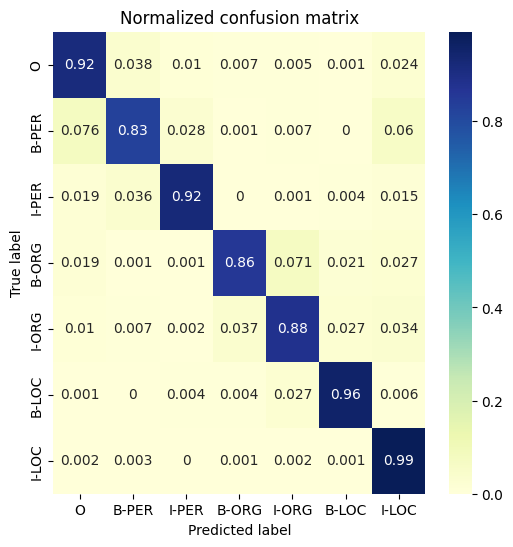

In [21]:
plot_confusion_matrix(
    y_true=list(chain.from_iterable(panx_ch_de_val['labels_str'].values.tolist())),
    y_pred=list(chain.from_iterable(panx_ch_de_val['preds_str'].values.tolist())),
    labels=id2label.values()
)

### My examples

In [22]:
tag_text(
    text='Ich bin Thomas ich komme aus Polen.',
    tags=tags,
    model=trainer.model,
    tokenizer=tokenizer,
    device=device
)

,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Ich,▁bin,▁Thomas,▁ich,▁komme,▁aus,▁Polen,.,</s>
input_ids,0,2484,2394,14978,654,9096,1312,89866,5,2
preds,O,O,O,B-PER,O,O,O,B-LOC,O,O


In [23]:
tag_text(
    text='Apple ist das größte Unternehmen in den Vereinigten Staaten.',
    tags=tags,
    model=trainer.model,
    tokenizer=tokenizer,
    device=device
)

,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,<s>,▁Apple,▁ist,▁das,▁größte,▁Unternehmen,▁in,▁den,▁Vereinigte,n,▁Staaten,.,</s>
input_ids,0,4129,443,381,119890,16104,23,168,231715,19,149225,5,2
preds,B-LOC,B-ORG,O,O,O,O,O,O,B-LOC,I-LOC,I-LOC,O,B-LOC
